In [1]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from itertools import product
import matplotlib.patches as mpatches

In [9]:
## Read samples location info
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
# file_name = 'dc_ALL_rounds_info.tsv'
file_name = 'dc_42_samples_info.tsv'

file_data = glob(dir_path + file_name)[0]
INFO = pd.read_csv(file_data, sep='\t')[['Sample_ID', 'country', 'year', 'post_dupe_depth']]
INFO.rename(columns={'Sample_ID':'sample', 
                     'country':'country', 
                     'year':'year', 
                     'post_dupe_depth':'depth'}, inplace=True)

In [10]:
countries_order = ['Indonesia', 'Solomon_Islands', 'Malaysia', 'Papua_New_Guinea', 'Mexico', 'Virgin_Islands',
                   'French_Guiana', 'Suriname', 'Costa_Rica', 'Ghana', 'Gabon', 'South_Africa']

## 1. Selected SNPs (Jamie)

### 1.1. Load genotypes

In [11]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/Jamie_snps/'
# file_name = 'snps_from_Jamie.genotypes.tsv'
file_name = 'derCor_42_samples.snps_from_Jamie.genotypes.tsv'

file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

## Assign location to each sample
df_all = pd.merge(df, INFO, on='sample')
# df_all[['ref_GT', 'alt_GT']] = df_all['genotype'].str.split('/', n=1, expand=True)
# df_all.head(3)
df_all[['chr', 'country', 'genotype']].tail(3)

,chr,country,genotype
277,SUPER_2_159956783,Solomon_Islands,1|1
278,SUPER_2_160113348,Solomon_Islands,1|1
279,SUPER_4_33969802,Solomon_Islands,0/0


### 1.2. Calculate total count and fraction of each genotype by country

In [12]:
grouped = pd.DataFrame(df_all.groupby(['chr', 'country', 'genotype', 'ref', 'alt']).size()).reset_index()
grouped.rename({0: 'count'}, axis='columns', inplace=True)

# Define all possible combinations of countries and genotypes
countries = df_all['country'].unique()
chroms = df_all['chr'].unique()
genotypes = ["0/0", "1/1", "0/1"]
all_combinations = pd.DataFrame(list(product(chroms, countries, genotypes)),
                                columns=['chr', 'country', 'genotype'])

# Merge to ensure all combinations are present, filling missing counts with 0
result = all_combinations.merge(grouped, on=['chr', 'country', 'genotype'], how='left').fillna(0)

# Convert count column to integer (since fillna converts it to float)
result['count'] = result['count'].astype(int)

# Calculate total count per country and add a fraction column
result['fraction'] = result.groupby(['chr', 'country'])['count'].transform(lambda x: x / x.sum() * 100)
result.head()

,chr,country,genotype,ref,alt,count,fraction
0,SUPER_1_159899979,Costa_Rica,0/0,G,A,9,100.0
1,SUPER_1_159899979,Costa_Rica,1/1,0,0,0,0.0
2,SUPER_1_159899979,Costa_Rica,0/1,0,0,0,0.0
3,SUPER_1_159899979,Virgin_Islands,0/0,G,A,1,100.0
4,SUPER_1_159899979,Virgin_Islands,1/1,0,0,0,0.0


### 1.3. For each selected SNP, plot genotypes by country

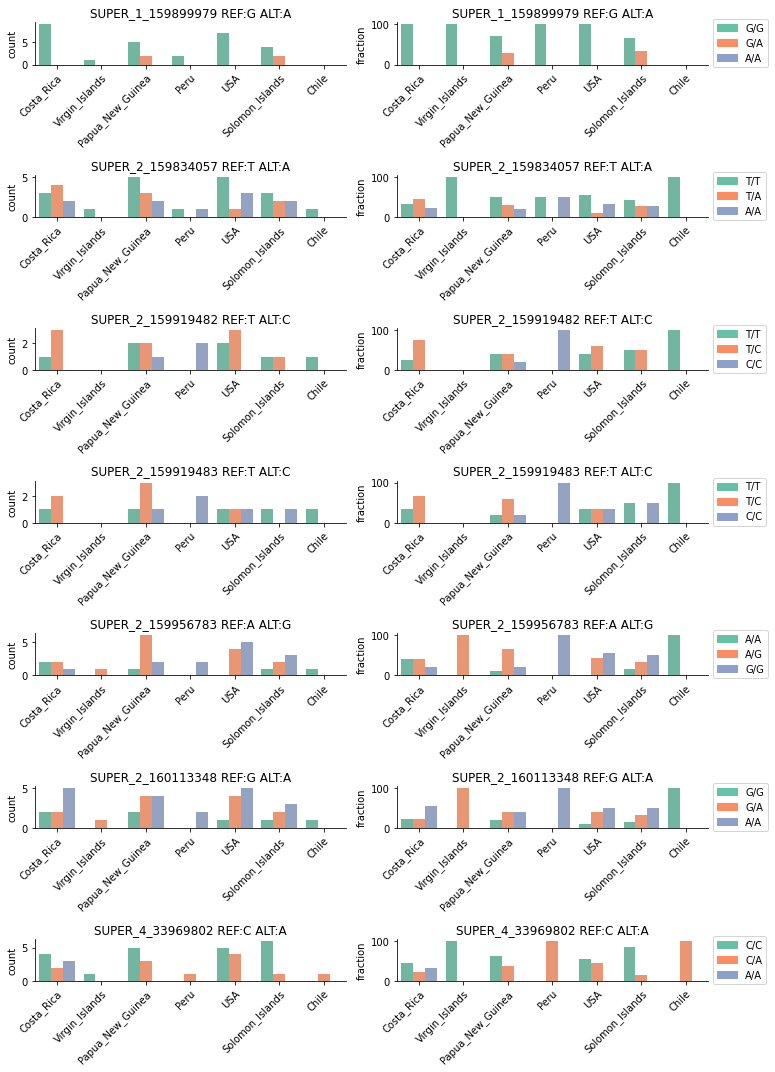

In [13]:
p = sns.color_palette('Set2')[:3]
sns.set_palette(p)

fig, axes = plt.subplots(len(chroms), 2, figsize = (11, 15))
values = ['count', 'fraction']

for i in range(len(chroms)):
    for j in range(len(values)):
        chrom = chroms[i]
        dfi = result[result['chr'] == chrom]
        v = values[j]

        ## Total count/fraction of each genotype
        axi = axes[i][j]
        sns.barplot(ax=axi, data=dfi, x='country', y=v, hue='genotype', 
                    #order=countries_order, 
                    hue_order=['0/0', '0/1', '1/1'])
        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        
        ## Annotate
        ref = list(np.trim_zeros(dfi['ref'].unique()))[0]
        alt = list(np.trim_zeros(dfi['alt'].unique()))[0]
        axi.set_xlabel('')
        axi.set_title('{} REF:{} ALT:{}'.format(chrom, ref, alt))
        
        ## Add custom legend
        patch_ref = mpatches.Patch(color=p[0], label='{}/{}'.format(ref, ref))
        patch_het = mpatches.Patch(color=p[1], label='{}/{}'.format(ref, alt))
        patch_alt = mpatches.Patch(color=p[2], label='{}/{}'.format(alt, alt))

        axi.get_legend().set_visible(False)
        if j == 1:
            axi.legend(
                handles=[patch_ref, patch_het, patch_alt], 
                loc="center left", 
                bbox_to_anchor=(1, 0.5))    
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()


pdf_name = 'derCor_42_samples.snps_from_Jamie_genotypes.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')